<a href="https://colab.research.google.com/github/wdgstl/ML4VA-UNET/blob/main/AtheroDataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulling Data From S3 using Boto3

In [ ]:
!pip install boto3

In [2]:
from google.colab import userdata
import boto3
import os

AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')
bucket_name = 'atherosclerosis-unet'
path_to_raw = 'images/raw_histology/'
path_to_mask = 'images/segmented_histology/'

s3 = boto3.client('s3',
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

local_dir_raw = 'downloaded_raw_images'
os.makedirs(local_dir_raw, exist_ok=True)

local_dir_masks = 'downloaded_mask_images'
os.makedirs(local_dir_masks, exist_ok=True)

In [3]:
s3_uri = 's3://atherosclerosis-unet/measurements/all_measurements/total_measurements_per_image.csv'

def parse_s3_uri(uri):
    if uri.startswith('s3://'):
        uri = uri[5:]
    bucket, key = uri.split('/', 1)
    return bucket, key

bucket_name, key = parse_s3_uri(s3_uri)

local_filename = os.path.basename(key)

s3.download_file(bucket_name, key, local_filename)

print(f'Downloaded {s3_uri} to {local_filename}')

Downloaded s3://atherosclerosis-unet/measurements/all_measurements/total_measurements_per_image.csv to total_measurements_per_image.csv


In [4]:
def download_all_objects(bucket_name, prefix, local_dir):
    os.makedirs(local_dir, exist_ok=True)
    print(f'Downloading from {prefix} to {local_dir}')

    continuation_token = None
    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

        for obj in response.get('Contents', []):
            key = obj['Key']
            if key.endswith('.tif'):
                file_name = os.path.basename(key)
                local_path = os.path.join(local_dir, file_name)
                s3.download_file(bucket_name, key, local_path)
                print(f'Downloaded: {file_name}')

        if response.get('IsTruncated'):
            continuation_token = response.get('NextContinuationToken')
        else:
            break

download_all_objects(bucket_name, path_to_raw, 'downloaded_raw_images')

download_all_objects(bucket_name, path_to_mask, 'downloaded_mask_images')


Streaming output truncated to the last 5000 lines.
Downloaded: 8390-6 4-4 4X.tif
Downloaded: 8390-6 4-5 4X.tif
Downloaded: 8390-6 4-6 4X.tif
Downloaded: 8390-6 4-7 4X.tif
Downloaded: 8390-6 4-8 4X.tif
Downloaded: 8390-6 4-9 4X.tif
Downloaded: 8390-6 5-2 4X.tif
Downloaded: 8390-6 5-3 4X.tif
Downloaded: 8391-12 3-10 4X.tif
Downloaded: 8391-12 3-11 4X.tif
Downloaded: 8391-12 3-12 4X.tif
Downloaded: 8391-12 3-2 4X.tif
Downloaded: 8391-12 3-3 4X.tif
Downloaded: 8391-12 3-4 4X.tif
Downloaded: 8391-12 3-5 4X.tif
Downloaded: 8391-12 3-6 4X.tif
Downloaded: 8391-12 3-7 4X.tif
Downloaded: 8391-12 3-8 4X.tif
Downloaded: 8391-12 3-9 4X.tif
Downloaded: 8391-12 4-1 4X.tif
Downloaded: 8391-12 4-2 4X.tif
Downloaded: 8391-12 4-3 4X.tif
Downloaded: 8391-12 4-4 4X.tif
Downloaded: 8391-12 4-5 4X.tif
Downloaded: 8391-12 4-6 4X.tif
Downloaded: 8391-12 4-7 4X.tif
Downloaded: 8391-12 4-8 4X.tif
Downloaded: 8391-12 4-9 4X.tif
Downloaded: 8448-26 4-10 4X.tif
Downloaded: 8448-26 4-11 4X.tif
Downloaded: 8448-26 4-

# Data Preprocessing Pipeline

In [5]:
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
def resize_with_aspect_ratio(type, x, size, direction):
    if type == 'mask':
        aspect_ratio = x.shape[1] / x.shape[0]
        new_size = (size)
        if aspect_ratio > 1:
            new_width = new_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = new_size[1]
            new_width = int(new_height * aspect_ratio)
        if direction == 'up':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        if direction == 'down':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_image = np.zeros((new_size[1], new_size[0]), dtype=np.uint8) * 255
        padding_left = (new_size[0] - new_width) // 2
        padding_top = (new_size[1] - new_height) // 2
        padded_image[padding_top:padding_top + new_height, padding_left:padding_left + new_width] = resized_image
    if type == 'image':
        aspect_ratio = x.shape[1] / x.shape[0]
        new_size = (size)
        if aspect_ratio > 1:
            new_width = new_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = new_size[1]
            new_width = int(new_height * aspect_ratio)
        if direction == 'up':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        if direction == 'down':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_image = np.ones((new_size[1], new_size[0], 3), dtype=np.uint8) * 255
        padding_left = (new_size[0] - new_width) // 2
        padding_top = (new_size[1] - new_height) // 2
        padded_image[padding_top:padding_top + new_height, padding_left:padding_left + new_width] = resized_image
    return padded_image

In [7]:
import cv2
import numpy as np
def read_image(path, input_size):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = resize_with_aspect_ratio('image', x, input_size, 'down')

    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path, input_size):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = resize_with_aspect_ratio('mask', x, input_size, 'down')  ## (h, w)
    x = x / 255.0  ## (h, w)
    x = x.astype(np.float32)  ## (h, w)
    x = np.expand_dims(x, axis=-1)  ## (h, w, 1)
    return x


In [8]:
im = read_image('/content/downloaded_raw_images/8390-1 3-10 4X.tif', input_size=(256,256))

im.shape

(256, 256, 3)

In [9]:
mask = read_mask('/content/downloaded_mask_images/8390-1 3-10 4X_mask.tif', input_size=(256,256))

mask.shape

(256, 256, 1)

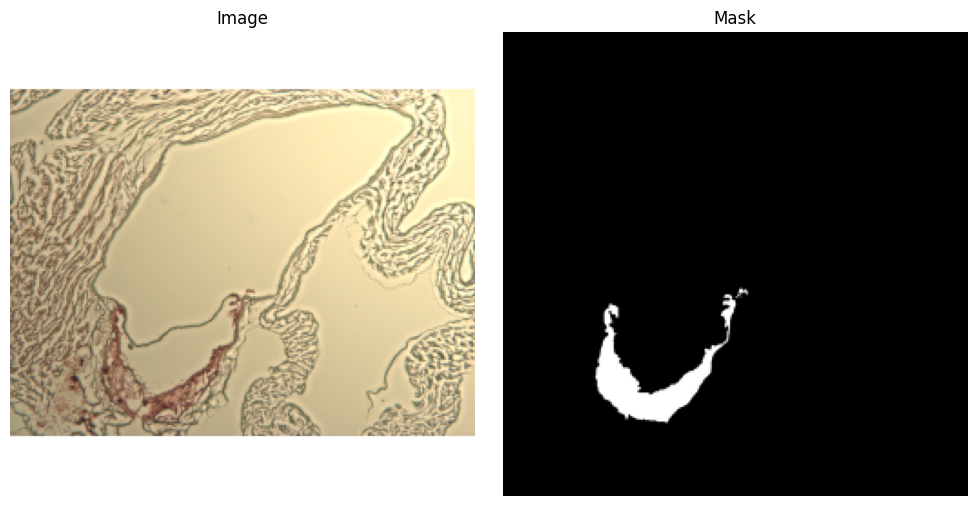

In [10]:
show_image_and_mask(im, mask)

In [11]:
import pandas as pd
from tqdm import tqdm
def convert_measurements_to_dict(path_to_measurements_csv):
    measurements_dict = {}
    measurements_df = pd.read_csv(path_to_measurements_csv)
    for row in measurements_df.iterrows():
        image_name = row[1]['Name']
        area = row[1]['Total_Area']
        measurements_dict[image_name] = area
    return measurements_dict


def load_dataset(image_dir, mask_dir, input_size, target_size=None):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    X = []
    y = []
    y_measurements = []

    name_to_area = convert_measurements_to_dict('/content/total_measurements_per_image.csv')

    for img_file, mask_file in tqdm(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        if img_path.endswith('.tif') and mask_path.endswith('.tif'):
          image = read_image(img_path, input_size = input_size)
          mask = read_mask(mask_path, input_size = input_size)

          X.append(image)
          y.append(mask)

          image_name = img_path.split("raw_images/")[1].split(".tif")[0]
          y_measurements.append(name_to_area[image_name])

    X = np.array(X)
    y = np.array(y)

    return X, y, y_measurements


In [29]:
from sklearn.model_selection import train_test_split
import os
X, y, y_measurements = load_dataset('/content/downloaded_raw_images/', '/content/downloaded_mask_images', input_size = (256, 256))

X_train, X_test, y_train, y_test, y_measurements_train, y_measurements_test = train_test_split(X, y, y_measurements, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, y_measurements_val, y_measurements_test = train_test_split(X_test, y_test, y_measurements_test, test_size=0.5, random_state=42)


2553it [00:48, 52.92it/s]


In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(2042, 256, 256, 3)
(255, 256, 256, 3)
(256, 256, 256, 3)


# UNET + Transformer Architecture

In [14]:
#Inspiration from https://arxiv.org/abs/2304.01401

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, LayerNormalization, MultiHeadAttention, Dense, GlobalAveragePooling2D, Reshape, Add
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def transformer_block(inputs, num_heads, ff_dim):
    x = Reshape((-1, inputs.shape[-1]))(inputs)

    x_norm = LayerNormalization(epsilon=1e-6)(x)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x_norm, x_norm)
    x = Add()([x, attn_output])

    x_norm = LayerNormalization(epsilon=1e-6)(x)
    ff_output = Dense(ff_dim, activation="relu")(x_norm)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    x = Add()([x, ff_output])

    spatial_dim = int(inputs.shape[1])
    x = Reshape((spatial_dim, spatial_dim, inputs.shape[-1]))(x)
    return x

def build_unet_transformer(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    t1 = transformer_block(b1, num_heads=4, ff_dim=1024)

    d1 = decoder_block(t1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET-TRANSFORMER")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet_transformer(input_shape)
    model.summary()


Model: "UNET-TRANSFORMER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 49,949,121 (190.54 MB)

 Trainable params: 49,937,345 (190.50 MB)

 Non-trainable params: 11,776 (46.00 KB)

# UNET Architecture

In [31]:
#Inspiration from https://github.com/nikhilroxtomar/Brain-Tumor-Segmentation-in-TensorFlow-2.0/blob/main/UNET/README.md

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ATHERO-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "ATHERO-UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_42[0][0] 

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Model Training

In [32]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


def train_unet(X_train, y_train, X_val, y_val,
        epochs, batch_size, lr, model_path):
    np.random.seed(42)
    tf.random.set_seed(42)

    H = X_train.shape[1]
    W = X_train.shape[2]

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(4)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.prefetch(4)


    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coefficient])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
    )
    return history

def train_unet_transformer(X_train, y_train, X_val, y_val,
        epochs, batch_size, lr, model_path):
    np.random.seed(42)
    tf.random.set_seed(42)

    H = X_train.shape[1]
    W = X_train.shape[2]

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(4)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.prefetch(4)


    model = build_unet_transformer((H,W,3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coefficient])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
    )
    return history

In [ ]:
params = {
    'epochs': 20,
    'batch_size': [2,4,6,8,10],
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1]
}

csv_path = "/content/unet_log.csv"

params_to_val = {}

for iter in range(4):
  model_path = f"/content/iter{iter}_unet_model.h5"
  epochs = params['epochs']
  batch_size = np.random.choice(params['batch_size'])
  lr = np.random.choice(params['lr'])
  history = train_unet(X_train, y_train, X_val, y_val,
            params['epochs'], batch_size, lr, model_path)
  val_dice_coeff = history.history['val_dice_coefficient'][-1]
  params_to_val[val_dice_coeff] = (iter, epochs, batch_size, lr)



In [ ]:
params_to_val

{0.043282777070999146: (3, 20, np.int64(8), np.float64(0.1)),
 6.478098613094119e-10: (2, 20, np.int64(8), np.float64(0.1))}

In [167]:
csv_path = "/content/unet_logs.csv"
model_path = "/content/unet_model_ml4va.h5"
epochs = 500
batch_size = 32
lr = 0.001

history = train_unet(X_train, y_train, X_val, y_val,
            epochs, batch_size, lr, model_path)


Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - dice_coefficient: 0.2254 - loss: 0.7746
Epoch 1: val_loss improved from inf to 0.95478, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 355ms/step - dice_coefficient: 0.2270 - loss: 0.7730 - val_dice_coefficient: 0.0452 - val_loss: 0.9548 - learning_rate: 0.0010
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - dice_coefficient: 0.5582 - loss: 0.4418
Epoch 2: val_loss improved from 0.95478 to 0.94909, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - dice_coefficient: 0.5589 - loss: 0.4411 - val_dice_coefficient: 0.0509 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.6994 - loss: 0.3006
Epoch 3: val_loss did not improve from 0.94909
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.6996 - loss: 0.3004 - val_dice_coefficient: 0.0040 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.7455 - loss: 0.2545
Epoch 4: val_loss did not improve from 0.94909
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.7456 - loss: 0.2544 - val_dice_coefficient: 0.0017 - val_loss: 0.9983 - learning_rate: 0.0010
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.7774 - loss: 0.2226
Epoch 5: val_loss did not improve from 0.94909
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.7774 - loss: 0.2226 - val_dice_coeff

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - dice_coefficient: 0.8207 - loss: 0.1793 - val_dice_coefficient: 0.3684 - val_loss: 0.6316 - learning_rate: 0.0010
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8367 - loss: 0.1633
Epoch 8: val_loss improved from 0.63156 to 0.29376, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.8366 - loss: 0.1634 - val_dice_coefficient: 0.7061 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 9/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8460 - loss: 0.1540
Epoch 9: val_loss did not improve from 0.29376
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8460 - loss: 0.1540 - val_dice_coefficient: 0.6811 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 10/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8522 - loss: 0.1478
Epoch 10: val_loss improved from 0.29376 to 0.18053, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.8521 - loss: 0.1479 - val_dice_coefficient: 0.8194 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 11/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8589 - loss: 0.1411
Epoch 11: val_loss did not improve from 0.18053
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8589 - loss: 0.1411 - val_dice_coefficient: 0.7974 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 12/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8653 - loss: 0.1347
Epoch 12: val_loss did not improve from 0.18053
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8653 - loss: 0.1347 - val_dice_coefficient: 0.7414 - val_loss: 0.2584 - learning_rate: 0.0010
Epoch 13/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8696 - loss: 0.1304
Epoch 13: val_loss did not improve from 0.18053
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8696 - loss: 0.1304 - val_dice

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.8738 - loss: 0.1262 - val_dice_coefficient: 0.8499 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 15/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8758 - loss: 0.1242
Epoch 15: val_loss did not improve from 0.15009
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8758 - loss: 0.1242 - val_dice_coefficient: 0.7276 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 16/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8770 - loss: 0.1230
Epoch 16: val_loss did not improve from 0.15009
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8770 - loss: 0.1230 - val_dice_coefficient: 0.8138 - val_loss: 0.1860 - learning_rate: 0.0010
Epoch 17/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8785 - loss: 0.1215
Epoch 17: val_loss improved from 0.15009 to 0.13417, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.8785 - loss: 0.1215 - val_dice_coefficient: 0.8658 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 18/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8816 - loss: 0.1184
Epoch 18: val_loss did not improve from 0.13417
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8816 - loss: 0.1184 - val_dice_coefficient: 0.8131 - val_loss: 0.1868 - learning_rate: 0.0010
Epoch 19/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8854 - loss: 0.1146
Epoch 19: val_loss did not improve from 0.13417
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8854 - loss: 0.1146 - val_dice_coefficient: 0.3952 - val_loss: 0.6046 - learning_rate: 0.0010
Epoch 20/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8832 - loss: 0.1168
Epoch 20: val_loss did not improve from 0.13417
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8832 - loss: 0.1168 - val_dice

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.8947 - loss: 0.1053 - val_dice_coefficient: 0.8801 - val_loss: 0.1198 - learning_rate: 1.0000e-04
Epoch 24/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8984 - loss: 0.1016
Epoch 24: val_loss did not improve from 0.11977
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8984 - loss: 0.1016 - val_dice_coefficient: 0.8787 - val_loss: 0.1213 - learning_rate: 1.0000e-04
Epoch 25/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.8996 - loss: 0.1004
Epoch 25: val_loss did not improve from 0.11977
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.8996 - loss: 0.1004 - val_dice_coefficient: 0.8791 - val_loss: 0.1208 - learning_rate: 1.0000e-04
Epoch 26/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9006 - loss: 0.0994
Epoch 26: val_loss did not improve from 0.11977
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9006 - loss: 0.099

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9013 - loss: 0.0987 - val_dice_coefficient: 0.8805 - val_loss: 0.1194 - learning_rate: 1.0000e-04
Epoch 28/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - dice_coefficient: 0.9019 - loss: 0.0981
Epoch 28: val_loss improved from 0.11940 to 0.11816, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9019 - loss: 0.0981 - val_dice_coefficient: 0.8817 - val_loss: 0.1182 - learning_rate: 1.0000e-04
Epoch 29/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9024 - loss: 0.0976
Epoch 29: val_loss improved from 0.11816 to 0.11762, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9024 - loss: 0.0976 - val_dice_coefficient: 0.8823 - val_loss: 0.1176 - learning_rate: 1.0000e-04
Epoch 30/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9028 - loss: 0.0972
Epoch 30: val_loss improved from 0.11762 to 0.11697, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9028 - loss: 0.0972 - val_dice_coefficient: 0.8829 - val_loss: 0.1170 - learning_rate: 1.0000e-04
Epoch 31/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9038 - loss: 0.0962
Epoch 31: val_loss did not improve from 0.11697
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9038 - loss: 0.0962 - val_dice_coefficient: 0.8829 - val_loss: 0.1171 - learning_rate: 1.0000e-04
Epoch 32/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9043 - loss: 0.0957
Epoch 32: val_loss improved from 0.11697 to 0.11672, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9043 - loss: 0.0957 - val_dice_coefficient: 0.8832 - val_loss: 0.1167 - learning_rate: 1.0000e-04
Epoch 33/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9047 - loss: 0.0953
Epoch 33: val_loss improved from 0.11672 to 0.11597, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - dice_coefficient: 0.9047 - loss: 0.0953 - val_dice_coefficient: 0.8839 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 34/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9051 - loss: 0.0949
Epoch 34: val_loss did not improve from 0.11597
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9051 - loss: 0.0949 - val_dice_coefficient: 0.8838 - val_loss: 0.1161 - learning_rate: 1.0000e-04
Epoch 35/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9056 - loss: 0.0944
Epoch 35: val_loss did not improve from 0.11597
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9056 - loss: 0.0944 - val_dice_coefficient: 0.8838 - val_loss: 0.1161 - learning_rate: 1.0000e-04
Epoch 36/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9061 - loss: 0.0939
Epoch 36: val_loss improved from 0.11597 to 0.11522, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9061 - loss: 0.0939 - val_dice_coefficient: 0.8847 - val_loss: 0.1152 - learning_rate: 1.0000e-04
Epoch 37/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9065 - loss: 0.0935
Epoch 37: val_loss improved from 0.11522 to 0.11441, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9065 - loss: 0.0935 - val_dice_coefficient: 0.8855 - val_loss: 0.1144 - learning_rate: 1.0000e-04
Epoch 38/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9069 - loss: 0.0931
Epoch 38: val_loss did not improve from 0.11441
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9069 - loss: 0.0931 - val_dice_coefficient: 0.8844 - val_loss: 0.1155 - learning_rate: 1.0000e-04
Epoch 39/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9073 - loss: 0.0927
Epoch 39: val_loss did not improve from 0.11441
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9073 - loss: 0.0927 - val_dice_coefficient: 0.8850 - val_loss: 0.1149 - learning_rate: 1.0000e-04
Epoch 40/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9078 - loss: 0.0922
Epoch 40: val_loss did not improve from 0.11441
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9078 - loss: 0.092

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9082 - loss: 0.0918 - val_dice_coefficient: 0.8857 - val_loss: 0.1142 - learning_rate: 1.0000e-04
Epoch 42/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9086 - loss: 0.0914
Epoch 42: val_loss did not improve from 0.11423
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9086 - loss: 0.0914 - val_dice_coefficient: 0.8846 - val_loss: 0.1153 - learning_rate: 1.0000e-04
Epoch 43/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9088 - loss: 0.0912
Epoch 43: val_loss did not improve from 0.11423
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9088 - loss: 0.0912 - val_dice_coefficient: 0.8842 - val_loss: 0.1157 - learning_rate: 1.0000e-04
Epoch 44/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9093 - loss: 0.0907
Epoch 44: val_loss did not improve from 0.11423
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9093 - loss: 0.090

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9105 - loss: 0.0895 - val_dice_coefficient: 0.8858 - val_loss: 0.1141 - learning_rate: 1.0000e-05
Epoch 48/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9105 - loss: 0.0895
Epoch 48: val_loss improved from 0.11415 to 0.11409, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9105 - loss: 0.0895 - val_dice_coefficient: 0.8858 - val_loss: 0.1141 - learning_rate: 1.0000e-05
Epoch 49/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9107 - loss: 0.0893
Epoch 49: val_loss improved from 0.11409 to 0.11398, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9107 - loss: 0.0893 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 50/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9108 - loss: 0.0892
Epoch 50: val_loss improved from 0.11398 to 0.11398, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9108 - loss: 0.0892 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 51/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9109 - loss: 0.0891
Epoch 51: val_loss did not improve from 0.11398
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - dice_coefficient: 0.9109 - loss: 0.0891 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 52/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9110 - loss: 0.0890
Epoch 52: val_loss did not improve from 0.11398
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9110 - loss: 0.0890 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 53/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9111 - loss: 0.0889
Epoch 53: val_loss improved from 0.11398 to 0.11397, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9111 - loss: 0.0889 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 54/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9112 - loss: 0.0888
Epoch 54: val_loss did not improve from 0.11397

Epoch 54: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9112 - loss: 0.0888 - val_dice_coefficient: 0.8859 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 55/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9111 - loss: 0.0889
Epoch 55: val_loss improved from 0.11397 to 0.11282, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9111 - loss: 0.0889 - val_dice_coefficient: 0.8871 - val_loss: 0.1128 - learning_rate: 1.0000e-06
Epoch 56/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9114 - loss: 0.0886
Epoch 56: val_loss improved from 0.11282 to 0.11272, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - dice_coefficient: 0.9114 - loss: 0.0886 - val_dice_coefficient: 0.8872 - val_loss: 0.1127 - learning_rate: 1.0000e-06
Epoch 57/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9114 - loss: 0.0886
Epoch 57: val_loss improved from 0.11272 to 0.11271, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - dice_coefficient: 0.9114 - loss: 0.0886 - val_dice_coefficient: 0.8872 - val_loss: 0.1127 - learning_rate: 1.0000e-06
Epoch 58/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9114 - loss: 0.0886
Epoch 58: val_loss improved from 0.11271 to 0.11271, saving model to /content/unet_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - dice_coefficient: 0.9114 - loss: 0.0886 - val_dice_coefficient: 0.8872 - val_loss: 0.1127 - learning_rate: 1.0000e-06
Epoch 59/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9114 - loss: 0.0886
Epoch 59: val_loss did not improve from 0.11271
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9114 - loss: 0.0886 - val_dice_coefficient: 0.8872 - val_loss: 0.1127 - learning_rate: 1.0000e-06
Epoch 60/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9114 - loss: 0.0886
Epoch 60: val_loss did not improve from 0.11271
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - dice_coefficient: 0.9114 - loss: 0.0886 - val_dice_coefficient: 0.8872 - val_loss: 0.1127 - learning_rate: 1.0000e-06
Epoch 61/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - dice_coefficient: 0.9115 - loss: 0.0885
Epoch 61: val_loss did not improve from 0.11271

Epoch 61: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
64/

KeyboardInterrupt: 

In [168]:
s3.upload_file("/content/unet_model_ml4va.h5", "atherosclerosis-unet", "models/unet_model_ml4va.h5")
s3.upload_file("/content/unet_logs.csv", "atherosclerosis-unet", "results/unet_logs.csv")

In [19]:
#Full Model Training
csv_path = "/content/unet_transformer_logs.csv"
model_path = "/content/unet_transformer_model_ml4va.h5"
epochs = 500
batch_size = 32
lr = 0.001

history = train_unet_transformer(X_train, y_train, X_val, y_val,
            epochs, batch_size, lr, model_path)


Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.2598 - loss: 0.7402   
Epoch 1: val_loss improved from inf to 0.94247, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - dice_coefficient: 0.2615 - loss: 0.7385 - val_dice_coefficient: 0.0575 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.5458 - loss: 0.4542
Epoch 2: val_loss did not improve from 0.94247
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.5462 - loss: 0.4538 - val_dice_coefficient: 0.0513 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.5997 - loss: 0.4003
Epoch 3: val_loss did not improve from 0.94247
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.5996 - loss: 0.4004 - val_dice_coefficient: 0.0435 - val_loss: 0.9565 - learning_rate: 0.0010
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.6332 - loss: 0.3668
Epoch 4: val_loss improved from 0.94247 to 0.90214, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.6333 - loss: 0.3667 - val_dice_coefficient: 0.0979 - val_loss: 0.9021 - learning_rate: 0.0010
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.6605 - loss: 0.3395
Epoch 5: val_loss improved from 0.90214 to 0.81396, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.6606 - loss: 0.3394 - val_dice_coefficient: 0.1861 - val_loss: 0.8140 - learning_rate: 0.0010
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7048 - loss: 0.2952
Epoch 6: val_loss did not improve from 0.81396
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.7049 - loss: 0.2952 - val_dice_coefficient: 0.1533 - val_loss: 0.8468 - learning_rate: 0.0010
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7158 - loss: 0.2842
Epoch 7: val_loss improved from 0.81396 to 0.41113, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.7159 - loss: 0.2841 - val_dice_coefficient: 0.5888 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7312 - loss: 0.2688
Epoch 8: val_loss did not improve from 0.41113
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.7311 - loss: 0.2689 - val_dice_coefficient: 0.5168 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 9/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7413 - loss: 0.2587
Epoch 9: val_loss improved from 0.41113 to 0.39382, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - dice_coefficient: 0.7414 - loss: 0.2586 - val_dice_coefficient: 0.6061 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 10/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7512 - loss: 0.2488
Epoch 10: val_loss did not improve from 0.39382
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.7511 - loss: 0.2489 - val_dice_coefficient: 0.2264 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 11/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7653 - loss: 0.2347
Epoch 11: val_loss improved from 0.39382 to 0.29505, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.7653 - loss: 0.2347 - val_dice_coefficient: 0.7049 - val_loss: 0.2951 - learning_rate: 0.0010
Epoch 12/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7720 - loss: 0.2280
Epoch 12: val_loss did not improve from 0.29505
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.7718 - loss: 0.2282 - val_dice_coefficient: 0.2414 - val_loss: 0.7586 - learning_rate: 0.0010
Epoch 13/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.7811 - loss: 0.2189
Epoch 13: val_loss improved from 0.29505 to 0.27489, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.7812 - loss: 0.2188 - val_dice_coefficient: 0.7250 - val_loss: 0.2749 - learning_rate: 0.0010
Epoch 14/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8022 - loss: 0.1978
Epoch 14: val_loss did not improve from 0.27489
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8022 - loss: 0.1978 - val_dice_coefficient: 0.6231 - val_loss: 0.3768 - learning_rate: 0.0010
Epoch 15/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8121 - loss: 0.1879
Epoch 15: val_loss improved from 0.27489 to 0.26877, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8122 - loss: 0.1878 - val_dice_coefficient: 0.7311 - val_loss: 0.2688 - learning_rate: 0.0010
Epoch 16/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8262 - loss: 0.1738
Epoch 16: val_loss improved from 0.26877 to 0.22339, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8262 - loss: 0.1738 - val_dice_coefficient: 0.7766 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 17/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8331 - loss: 0.1669
Epoch 17: val_loss did not improve from 0.22339
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8331 - loss: 0.1669 - val_dice_coefficient: 0.2220 - val_loss: 0.7778 - learning_rate: 0.0010
Epoch 18/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8369 - loss: 0.1631
Epoch 18: val_loss did not improve from 0.22339
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8368 - loss: 0.1632 - val_dice_coefficient: 0.7164 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 19/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8391 - loss: 0.1609
Epoch 19: val_loss did not improve from 0.22339
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8389 - loss: 0.1611 - val_dice

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8423 - loss: 0.1577 - val_dice_coefficient: 0.8089 - val_loss: 0.1911 - learning_rate: 1.0000e-04
Epoch 23/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8528 - loss: 0.1472
Epoch 23: val_loss improved from 0.19107 to 0.17781, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8528 - loss: 0.1472 - val_dice_coefficient: 0.8221 - val_loss: 0.1778 - learning_rate: 1.0000e-04
Epoch 24/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8540 - loss: 0.1460
Epoch 24: val_loss improved from 0.17781 to 0.16473, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8540 - loss: 0.1460 - val_dice_coefficient: 0.8352 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 25/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8572 - loss: 0.1428
Epoch 25: val_loss improved from 0.16473 to 0.16408, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8571 - loss: 0.1429 - val_dice_coefficient: 0.8358 - val_loss: 0.1641 - learning_rate: 1.0000e-04
Epoch 26/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8588 - loss: 0.1412
Epoch 26: val_loss did not improve from 0.16408
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8588 - loss: 0.1412 - val_dice_coefficient: 0.8357 - val_loss: 0.1642 - learning_rate: 1.0000e-04
Epoch 27/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8600 - loss: 0.1400
Epoch 27: val_loss improved from 0.16408 to 0.15461, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - dice_coefficient: 0.8599 - loss: 0.1401 - val_dice_coefficient: 0.8453 - val_loss: 0.1546 - learning_rate: 1.0000e-04
Epoch 28/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8619 - loss: 0.1381
Epoch 28: val_loss did not improve from 0.15461
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8619 - loss: 0.1381 - val_dice_coefficient: 0.8441 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 29/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8633 - loss: 0.1367
Epoch 29: val_loss did not improve from 0.15461
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8633 - loss: 0.1367 - val_dice_coefficient: 0.8251 - val_loss: 0.1748 - learning_rate: 1.0000e-04
Epoch 30/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8639 - loss: 0.1361
Epoch 30: val_loss did not improve from 0.15461
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8639 - loss: 0.136

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8650 - loss: 0.1350 - val_dice_coefficient: 0.8472 - val_loss: 0.1527 - learning_rate: 1.0000e-04
Epoch 32/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8656 - loss: 0.1344
Epoch 32: val_loss did not improve from 0.15271
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8656 - loss: 0.1344 - val_dice_coefficient: 0.8431 - val_loss: 0.1568 - learning_rate: 1.0000e-04
Epoch 33/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8675 - loss: 0.1325
Epoch 33: val_loss did not improve from 0.15271
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8675 - loss: 0.1325 - val_dice_coefficient: 0.8449 - val_loss: 0.1551 - learning_rate: 1.0000e-04
Epoch 34/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8666 - loss: 0.1334
Epoch 34: val_loss did not improve from 0.15271
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8666 - loss: 0.133

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8695 - loss: 0.1305 - val_dice_coefficient: 0.8583 - val_loss: 0.1416 - learning_rate: 1.0000e-05
Epoch 38/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8706 - loss: 0.1294
Epoch 38: val_loss improved from 0.14160 to 0.14084, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8706 - loss: 0.1294 - val_dice_coefficient: 0.8591 - val_loss: 0.1408 - learning_rate: 1.0000e-05
Epoch 39/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8712 - loss: 0.1288
Epoch 39: val_loss did not improve from 0.14084
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8712 - loss: 0.1288 - val_dice_coefficient: 0.8589 - val_loss: 0.1410 - learning_rate: 1.0000e-05
Epoch 40/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8715 - loss: 0.1285
Epoch 40: val_loss did not improve from 0.14084
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8715 - loss: 0.1285 - val_dice_coefficient: 0.8585 - val_loss: 0.1414 - learning_rate: 1.0000e-05
Epoch 41/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8717 - loss: 0.1283
Epoch 41: val_loss improved from 0.14084 to 0.14048, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - dice_coefficient: 0.8717 - loss: 0.1283 - val_dice_coefficient: 0.8595 - val_loss: 0.1405 - learning_rate: 1.0000e-05
Epoch 42/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8720 - loss: 0.1280
Epoch 42: val_loss improved from 0.14048 to 0.14044, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8720 - loss: 0.1280 - val_dice_coefficient: 0.8595 - val_loss: 0.1404 - learning_rate: 1.0000e-05
Epoch 43/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8722 - loss: 0.1278
Epoch 43: val_loss improved from 0.14044 to 0.14014, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8721 - loss: 0.1279 - val_dice_coefficient: 0.8598 - val_loss: 0.1401 - learning_rate: 1.0000e-05
Epoch 44/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8723 - loss: 0.1277
Epoch 44: val_loss improved from 0.14014 to 0.13958, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8723 - loss: 0.1277 - val_dice_coefficient: 0.8604 - val_loss: 0.1396 - learning_rate: 1.0000e-05
Epoch 45/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8725 - loss: 0.1275
Epoch 45: val_loss did not improve from 0.13958
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8725 - loss: 0.1275 - val_dice_coefficient: 0.8601 - val_loss: 0.1398 - learning_rate: 1.0000e-05
Epoch 46/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8726 - loss: 0.1274
Epoch 46: val_loss improved from 0.13958 to 0.13937, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8726 - loss: 0.1274 - val_dice_coefficient: 0.8606 - val_loss: 0.1394 - learning_rate: 1.0000e-05
Epoch 47/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8728 - loss: 0.1272
Epoch 47: val_loss improved from 0.13937 to 0.13918, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8728 - loss: 0.1272 - val_dice_coefficient: 0.8608 - val_loss: 0.1392 - learning_rate: 1.0000e-05
Epoch 48/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8729 - loss: 0.1271
Epoch 48: val_loss improved from 0.13918 to 0.13886, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8729 - loss: 0.1271 - val_dice_coefficient: 0.8611 - val_loss: 0.1389 - learning_rate: 1.0000e-05
Epoch 49/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8731 - loss: 0.1269
Epoch 49: val_loss improved from 0.13886 to 0.13883, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8731 - loss: 0.1269 - val_dice_coefficient: 0.8611 - val_loss: 0.1388 - learning_rate: 1.0000e-05
Epoch 50/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8732 - loss: 0.1268
Epoch 50: val_loss improved from 0.13883 to 0.13880, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8732 - loss: 0.1268 - val_dice_coefficient: 0.8611 - val_loss: 0.1388 - learning_rate: 1.0000e-05
Epoch 51/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8733 - loss: 0.1267
Epoch 51: val_loss improved from 0.13880 to 0.13861, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8733 - loss: 0.1267 - val_dice_coefficient: 0.8613 - val_loss: 0.1386 - learning_rate: 1.0000e-05
Epoch 52/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8734 - loss: 0.1266
Epoch 52: val_loss improved from 0.13861 to 0.13837, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8734 - loss: 0.1266 - val_dice_coefficient: 0.8616 - val_loss: 0.1384 - learning_rate: 1.0000e-05
Epoch 53/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8736 - loss: 0.1264
Epoch 53: val_loss did not improve from 0.13837
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8736 - loss: 0.1264 - val_dice_coefficient: 0.8615 - val_loss: 0.1384 - learning_rate: 1.0000e-05
Epoch 54/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8737 - loss: 0.1263
Epoch 54: val_loss did not improve from 0.13837
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8737 - loss: 0.1263 - val_dice_coefficient: 0.8616 - val_loss: 0.1384 - learning_rate: 1.0000e-05
Epoch 55/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8738 - loss: 0.1262
Epoch 55: val_loss improved from 0.13837 to 0.13791, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8738 - loss: 0.1262 - val_dice_coefficient: 0.8620 - val_loss: 0.1379 - learning_rate: 1.0000e-05
Epoch 56/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8740 - loss: 0.1260
Epoch 56: val_loss did not improve from 0.13791
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8740 - loss: 0.1260 - val_dice_coefficient: 0.8614 - val_loss: 0.1385 - learning_rate: 1.0000e-05
Epoch 57/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8741 - loss: 0.1259
Epoch 57: val_loss did not improve from 0.13791
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8741 - loss: 0.1259 - val_dice_coefficient: 0.8620 - val_loss: 0.1380 - learning_rate: 1.0000e-05
Epoch 58/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8742 - loss: 0.1258
Epoch 58: val_loss did not improve from 0.13791
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8742 - loss: 0.125

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8743 - loss: 0.1257 - val_dice_coefficient: 0.8622 - val_loss: 0.1377 - learning_rate: 1.0000e-05
Epoch 60/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8745 - loss: 0.1255
Epoch 60: val_loss did not improve from 0.13773
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8745 - loss: 0.1255 - val_dice_coefficient: 0.8620 - val_loss: 0.1380 - learning_rate: 1.0000e-05
Epoch 61/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8746 - loss: 0.1254
Epoch 61: val_loss did not improve from 0.13773
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8746 - loss: 0.1254 - val_dice_coefficient: 0.8621 - val_loss: 0.1378 - learning_rate: 1.0000e-05
Epoch 62/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8747 - loss: 0.1253
Epoch 62: val_loss improved from 0.13773 to 0.13765, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8747 - loss: 0.1253 - val_dice_coefficient: 0.8623 - val_loss: 0.1376 - learning_rate: 1.0000e-05
Epoch 63/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8748 - loss: 0.1252
Epoch 63: val_loss did not improve from 0.13765
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8748 - loss: 0.1252 - val_dice_coefficient: 0.8619 - val_loss: 0.1381 - learning_rate: 1.0000e-05
Epoch 64/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8749 - loss: 0.1251
Epoch 64: val_loss did not improve from 0.13765

Epoch 64: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8749 - loss: 0.1251 - val_dice_coefficient: 0.8620 - val_loss: 0.1379 - learning_rate: 1.0000e-05
Epoch 65/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8750 - loss: 0.1250
Epoch 65: val_loss improved from 0.13765 to 0.13744

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8750 - loss: 0.1250 - val_dice_coefficient: 0.8625 - val_loss: 0.1374 - learning_rate: 1.0000e-06
Epoch 66/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8752 - loss: 0.1248
Epoch 66: val_loss improved from 0.13744 to 0.13732, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8751 - loss: 0.1249 - val_dice_coefficient: 0.8626 - val_loss: 0.1373 - learning_rate: 1.0000e-06
Epoch 67/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8752 - loss: 0.1248
Epoch 67: val_loss improved from 0.13732 to 0.13729, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8752 - loss: 0.1248 - val_dice_coefficient: 0.8626 - val_loss: 0.1373 - learning_rate: 1.0000e-06
Epoch 68/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8752 - loss: 0.1248
Epoch 68: val_loss improved from 0.13729 to 0.13721, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8752 - loss: 0.1248 - val_dice_coefficient: 0.8627 - val_loss: 0.1372 - learning_rate: 1.0000e-06
Epoch 69/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8753 - loss: 0.1247
Epoch 69: val_loss improved from 0.13721 to 0.13719, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - dice_coefficient: 0.8753 - loss: 0.1247 - val_dice_coefficient: 0.8627 - val_loss: 0.1372 - learning_rate: 1.0000e-06
Epoch 70/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8753 - loss: 0.1247
Epoch 70: val_loss did not improve from 0.13719
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8753 - loss: 0.1247 - val_dice_coefficient: 0.8626 - val_loss: 0.1373 - learning_rate: 1.0000e-06
Epoch 71/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8753 - loss: 0.1247
Epoch 71: val_loss improved from 0.13719 to 0.13716, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - dice_coefficient: 0.8753 - loss: 0.1247 - val_dice_coefficient: 0.8628 - val_loss: 0.1372 - learning_rate: 1.0000e-06
Epoch 72/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8753 - loss: 0.1247
Epoch 72: val_loss did not improve from 0.13716
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8753 - loss: 0.1247 - val_dice_coefficient: 0.8628 - val_loss: 0.1372 - learning_rate: 1.0000e-06
Epoch 73/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 73: val_loss improved from 0.13716 to 0.13707, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - dice_coefficient: 0.8753 - loss: 0.1247 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-06
Epoch 74/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 74: val_loss improved from 0.13707 to 0.13707, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8754 - loss: 0.1246 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-06
Epoch 75/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 75: val_loss did not improve from 0.13707
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8754 - loss: 0.1246 - val_dice_coefficient: 0.8628 - val_loss: 0.1371 - learning_rate: 1.0000e-06
Epoch 76/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 76: val_loss improved from 0.13707 to 0.13707, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8754 - loss: 0.1246 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-06
Epoch 77/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 77: val_loss did not improve from 0.13707
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8754 - loss: 0.1246 - val_dice_coefficient: 0.8628 - val_loss: 0.1372 - learning_rate: 1.0000e-06
Epoch 78/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8754 - loss: 0.1246
Epoch 78: val_loss improved from 0.13707 to 0.13705, saving model to /content/unet_transformer_model_ml4va.h5



Epoch 78: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8754 - loss: 0.1246 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-06
Epoch 79/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 79: val_loss did not improve from 0.13705
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 80/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 80: val_loss did not improve from 0.13705
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 81/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 81: val_loss did not improve from 0.13705
64/

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 85/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 85: val_loss improved from 0.13705 to 0.13705, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 86/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 86: val_loss did not improve from 0.13705
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 87/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 87: val_loss improved from 0.13705 to 0.13705, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1371 - learning_rate: 1.0000e-07
Epoch 88/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 88: val_loss improved from 0.13705 to 0.13705, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 89/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 89: val_loss improved from 0.13705 to 0.13705, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 90/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 90: val_loss improved from 0.13705 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 91/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 91: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 92/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 92: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 93/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 93: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 94/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 94: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 95/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 95: val_loss did not improve from 0.13704
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 96/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 96: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 97/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 97: val_loss improved from 0.13704 to 0.13704, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 98/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 98: val_loss improved from 0.13704 to 0.13703, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 99/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coefficient: 0.8755 - loss: 0.1245
Epoch 99: val_loss improved from 0.13703 to 0.13703, saving model to /content/unet_transformer_model_ml4va.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - dice_coefficient: 0.8755 - loss: 0.1245 - val_dice_coefficient: 0.8629 - val_loss: 0.1370 - learning_rate: 1.0000e-07
Epoch 100/500
34/64 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - dice_coefficient: 0.8757 - loss: 0.1243

KeyboardInterrupt: 

In [22]:
s3.upload_file("/content/unet_transformer_model_ml4va.h5", "atherosclerosis-unet", "models/unet_transformer_model_ml4va.h5")

In [23]:
s3.upload_file("/content/unet_transformer_logs.csv", "atherosclerosis-unet", "results/unet_transformer_logs.csv")

In [48]:
s3_uri = 's3://atherosclerosis-unet/results/unet_logs.csv'
s3_uri_2 = 's3://atherosclerosis-unet/results/unet_transformer_logs.csv'

def parse_s3_uri(uri):
    if uri.startswith('s3://'):
        uri = uri[5:]
    bucket, key = uri.split('/', 1)
    return bucket, key

bucket_name_1, key_1 = parse_s3_uri(s3_uri)
bucket_name_2, key_2 = parse_s3_uri(s3_uri_2)

local_filename_1 = os.path.basename(key_1)
local_filename_2 = os.path.basename(key_2)

s3.download_file(bucket_name_1, key_1, local_filename_1)
s3.download_file(bucket_name_2, key_2, local_filename_2)

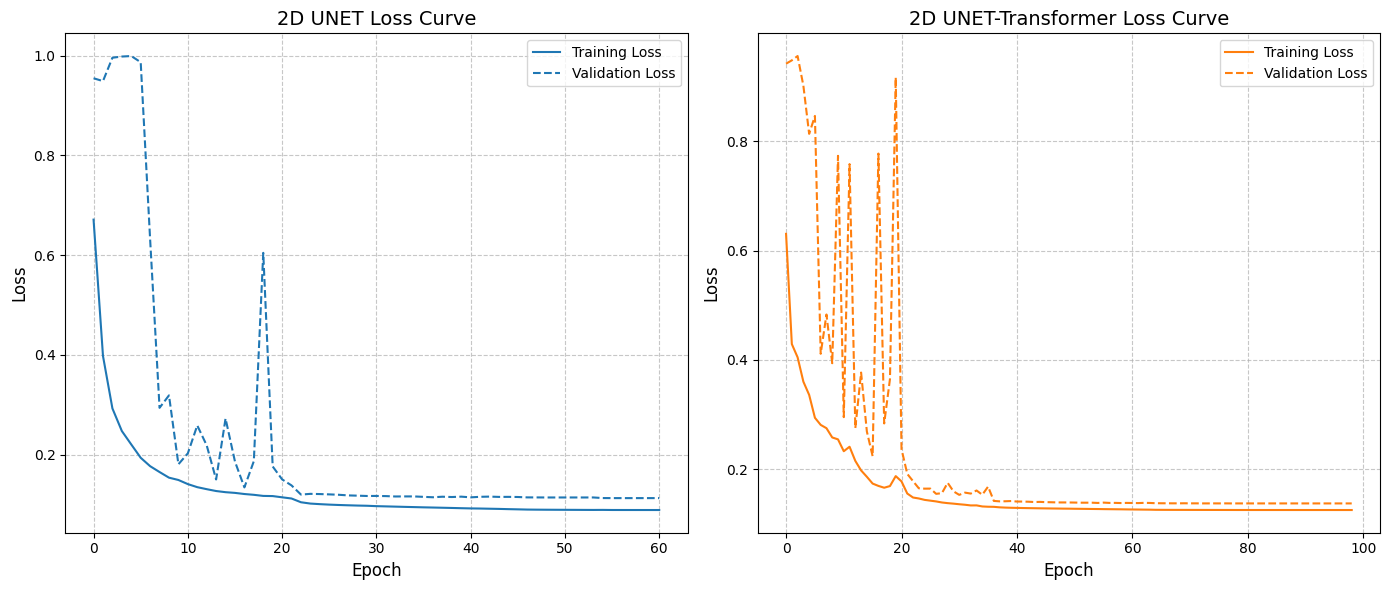

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

path_to_unet_csv = '/content/unet_logs.csv'
path_to_transformer_csv = '/content/unet_transformer_logs.csv'

df_unet = pd.read_csv(path_to_unet_csv)
df_transformer = pd.read_csv(path_to_transformer_csv)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(df_unet['epoch'], df_unet['loss'], label='Training Loss', color='tab:blue', linestyle='-')
axes[0].plot(df_unet['epoch'], df_unet['val_loss'], label='Validation Loss', color='tab:blue', linestyle='--')
axes[0].set_title('2D UNET Loss Curve', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].plot(df_transformer['epoch'], df_transformer['loss'], label='Training Loss', color='tab:orange', linestyle='-')
axes[1].plot(df_transformer['epoch'], df_transformer['val_loss'], label='Validation Loss', color='tab:orange', linestyle='--')
axes[1].set_title('2D UNET-Transformer Loss Curve', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Model Inference

In [19]:
#Load models from s3
s3_uri = 's3://atherosclerosis-unet/models/unet_model_ml4va.h5'
s3_uri_2 = 's3://atherosclerosis-unet/models/unet_transformer_model_ml4va.h5'

def parse_s3_uri(uri):
    if uri.startswith('s3://'):
        uri = uri[5:]
    bucket, key = uri.split('/', 1)
    return bucket, key

bucket_name_1, key_1 = parse_s3_uri(s3_uri)
bucket_name_2, key_2 = parse_s3_uri(s3_uri_2)

local_filename_1 = os.path.basename(key_1)
local_filename_2 = os.path.basename(key_2)

s3.download_file(bucket_name_1, key_1, local_filename_1)
s3.download_file(bucket_name_2, key_2, local_filename_2)


In [35]:
from tensorflow.keras.utils import CustomObjectScope

with CustomObjectScope({"dice_coefficient": dice_coefficient, "dice_loss": dice_loss}):
        unet = tf.keras.models.load_model(
            os.path.join("/content/unet_model_ml4va.h5"))
        unet_transformer = tf.keras.models.load_model(
            os.path.join("/content/unet_transformer_model_ml4va.h5"))


In [91]:
x = X_test[5]

sample_batch = np.expand_dims(x, axis=0)

output = unet_transformer.predict(sample_batch)

output = np.squeeze(output, axis=0)
output = np.squeeze(output, axis=-1)

y_pred = (output >= 0.5).astype(np.int32)

y_true = y_test[5]
y_true = np.squeeze(y_true, axis=-1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


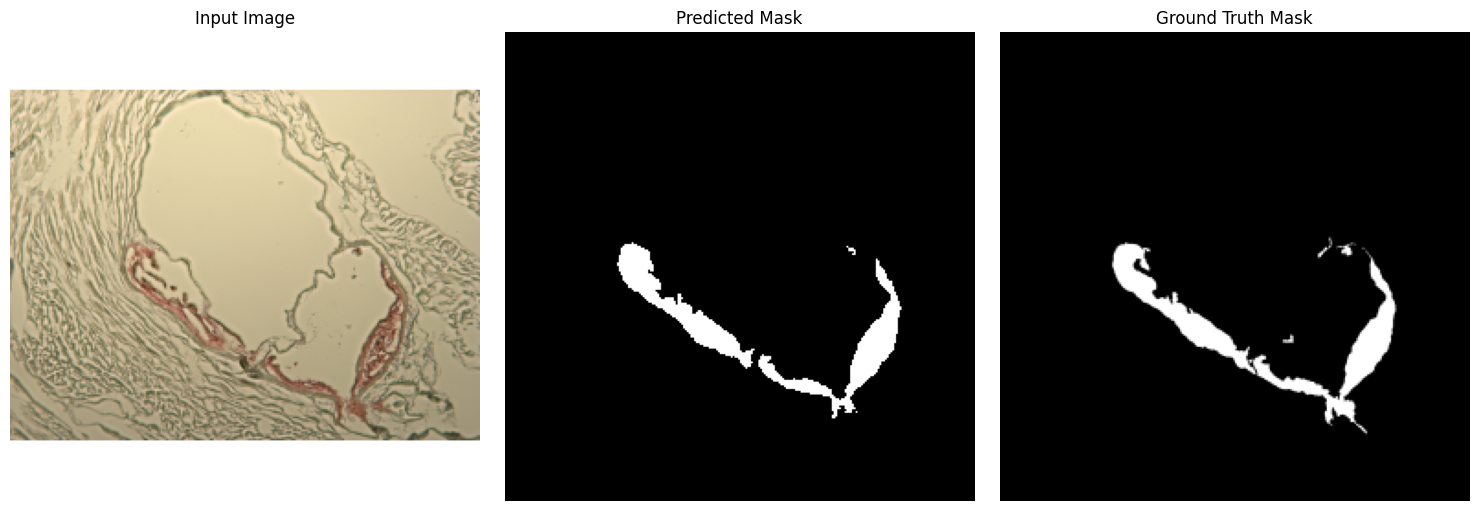

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(x)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_true, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


# Segmentation Analysis

### UNET + Transformer


In [22]:
#Overal Stats
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, roc_auc_score

y_pred = unet_transformer.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_true_bin = (y_test > 0.5).astype(np.uint8)

y_true_flat = y_true_bin.flatten()
y_pred_flat = y_pred_bin.flatten()


dice = f1_score(y_true_flat, y_pred_flat)

iou = jaccard_score(y_true_flat, y_pred_flat)

accuracy = accuracy_score(y_true_flat, y_pred_flat)

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)


test_metrics = unet_transformer.evaluate(X_test, y_test)
print(f"Test Loss: {test_metrics[0]}, Test Dice Coefficient: {test_metrics[1]}")

print(f'Dice {dice}')
print(f'IOU {iou}')
print(f'Accuracy {accuracy}')
print(f'Precision {precision}')
print(f'Recall {recall}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - dice_coefficient: 0.8477 - loss: 0.1523
Test Loss: 0.14424872398376465, Test Dice Coefficient: 0.8557512760162354
Dice 0.8721389322298352
IOU 0.7732680532666097
Accuracy 0.9943828582763672
Precision 0.8773191683340202
Recall 0.8670195116819216


In [23]:
#Stats for Each Test Image
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.astype(np.float32).flatten()
    y_pred_f = y_pred.astype(np.float32).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return (tp + smooth) / (tp + fp + smooth)

def recall_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return (tp + smooth) / (tp + fn + smooth)

dice_scores = []
iou_scores = []
pixel_accuracies = []
precisions = []
recalls = []

for x, y_true in zip(X_test, y_test):
    x_input = np.expand_dims(x, axis=0)
    pred = unet_transformer.predict(x_input)[0]

    # Clean shapes
    pred = np.squeeze(pred)
    y_true = np.squeeze(y_true)

    pred_bin = (pred > 0.5).astype(np.uint8)
    y_true_bin = (y_true > 0.5).astype(np.uint8)

    dice_scores.append(dice_coefficient(y_true_bin, pred_bin))
    iou_scores.append(iou_score(y_true_bin, pred_bin))
    pixel_accuracies.append(pixel_accuracy(y_true_bin, pred_bin))
    precisions.append(precision_score(y_true_bin, pred_bin))
    recalls.append(recall_score(y_true_bin, pred_bin))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


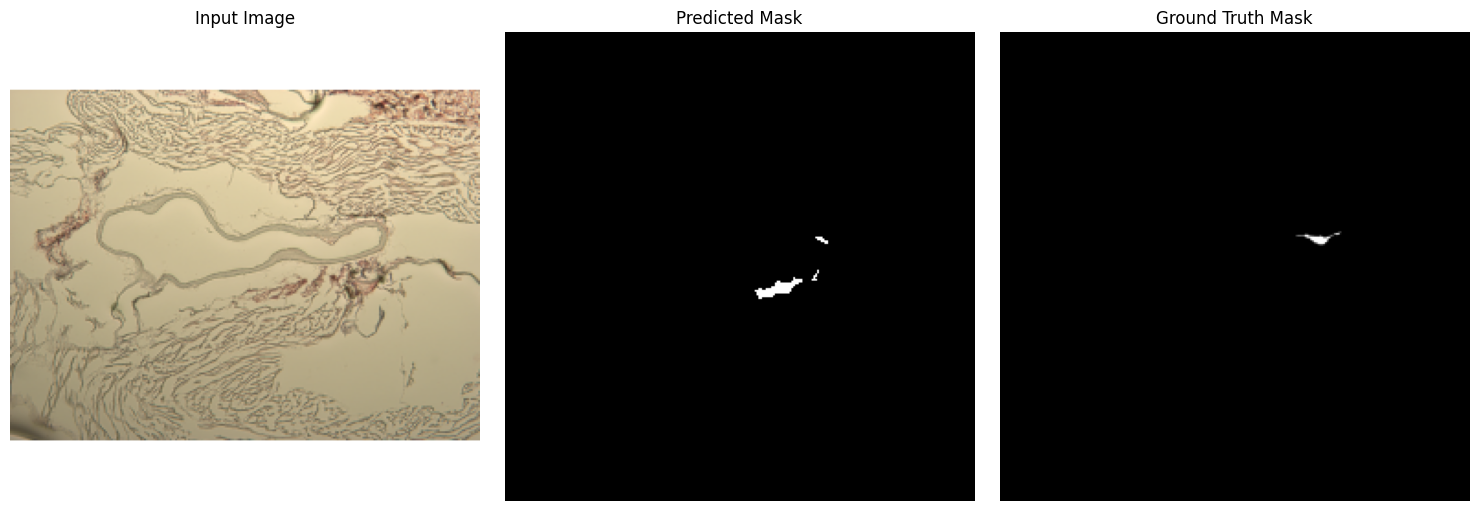

In [93]:
#Worst Prediction
idx = np.argmin(dice_scores)
x = X_test[idx]

sample_batch = np.expand_dims(x, axis=0)

output = unet_transformer.predict(sample_batch)

output = np.squeeze(output, axis=0)     # (height, width, 1)
output = np.squeeze(output, axis=-1)    # (height, width)

y_pred = (output >= 0.5).astype(np.int32)  # (height, width)

y_true = y_test[idx]
y_true = np.squeeze(y_true, axis=-1)

plt.figure(figsize=(15, 5))  # Wider figure for three images

plt.subplot(1, 3, 1)
plt.imshow(x)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_true, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


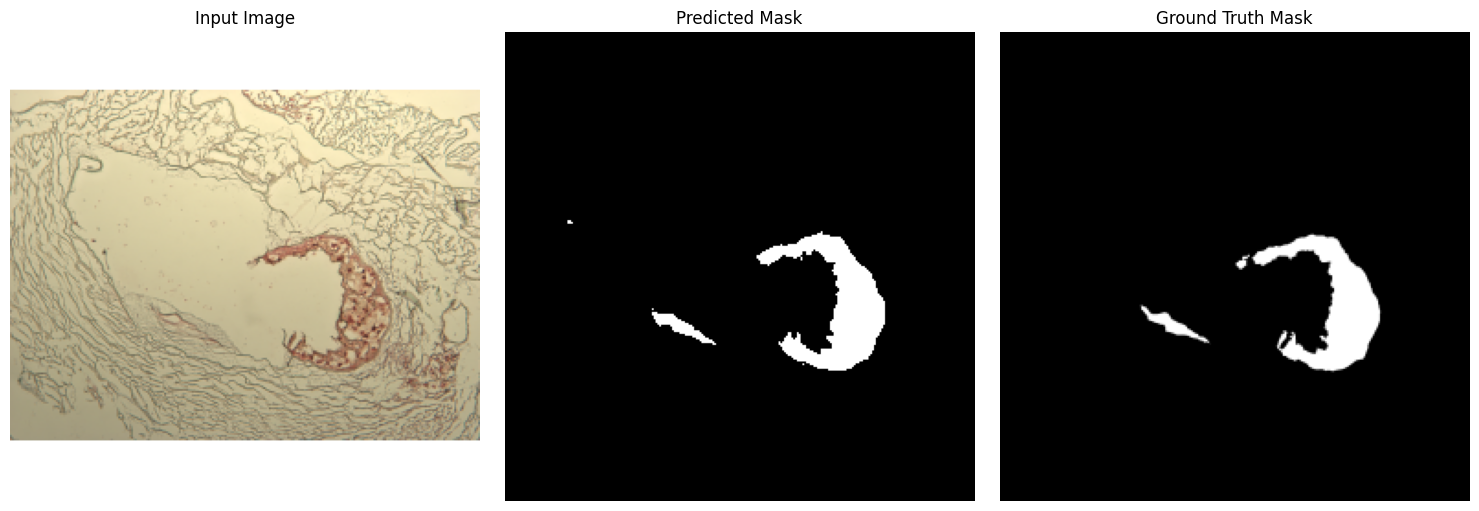

In [25]:
#Best Prediction
idx = np.argmax(dice_scores)
x = X_test[idx]

sample_batch = np.expand_dims(x, axis=0)

output = unet_transformer.predict(sample_batch)

output = np.squeeze(output, axis=0)     # (height, width, 1)
output = np.squeeze(output, axis=-1)    # (height, width)

y_pred = (output >= 0.5).astype(np.int32)  # (height, width)

y_true = y_test[idx]
y_true = np.squeeze(y_true, axis=-1)

plt.figure(figsize=(15, 5))  # Wider figure for three images

plt.subplot(1, 3, 1)
plt.imshow(x)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_true, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Dice vs. Mask Size')

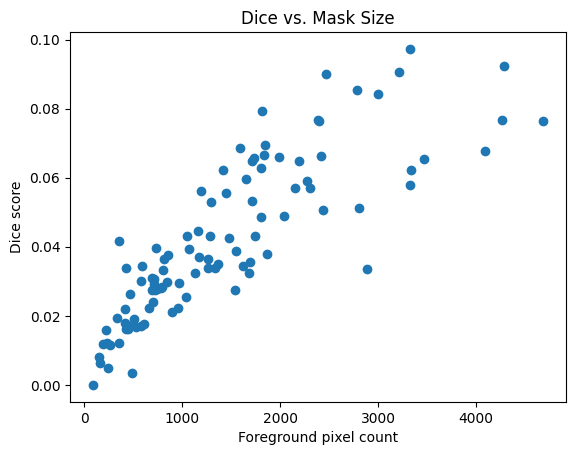

In [ ]:
mask_sizes = [np.sum(mask) for mask in y_test]
plt.scatter(mask_sizes, dice_scores)
plt.xlabel("Foreground pixel count")
plt.ylabel("Dice score")
plt.title("Dice vs. Mask Size")


### UNET

In [94]:
#Overal Stats
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, roc_auc_score

y_pred = unet.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_true_bin = (y_test > 0.5).astype(np.uint8)

y_true_flat = y_true_bin.flatten()
y_pred_flat = y_pred_bin.flatten()


dice = f1_score(y_true_flat, y_pred_flat)

iou = jaccard_score(y_true_flat, y_pred_flat)

accuracy = accuracy_score(y_true_flat, y_pred_flat)

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)


test_metrics = unet.evaluate(X_test, y_test)
print(f"Test Loss: {test_metrics[0]}, Test Dice Coefficient: {test_metrics[1]}")

print(f'Dice {dice}')
print(f'IOU {iou}')
print(f'Accuracy {accuracy}')
print(f'Precision {precision}')
print(f'Recall {recall}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - dice_coefficient: 0.8715 - loss: 0.1285
Test Loss: 0.1201140284538269, Test Dice Coefficient: 0.8798859715461731
Dice 0.8986613860955827
IOU 0.8159719224859353
Accuracy 0.995552659034729
Precision 0.9049518166873186
Recall 0.892457802919334


In [96]:
#Stats for Each Test Image
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.astype(np.float32).flatten()
    y_pred_f = y_pred.astype(np.float32).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return (tp + smooth) / (tp + fp + smooth)

def recall_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return (tp + smooth) / (tp + fn + smooth)

dice_scores = []
iou_scores = []
pixel_accuracies = []
precisions = []
recalls = []

for x, y_true in zip(X_test, y_test):
    x_input = np.expand_dims(x, axis=0)
    pred = unet.predict(x_input)[0]

    # Clean shapes
    pred = np.squeeze(pred)
    y_true = np.squeeze(y_true)

    pred_bin = (pred > 0.5).astype(np.uint8)
    y_true_bin = (y_true > 0.5).astype(np.uint8)

    dice_scores.append(dice_coefficient(y_true_bin, pred_bin))
    iou_scores.append(iou_score(y_true_bin, pred_bin))
    pixel_accuracies.append(pixel_accuracy(y_true_bin, pred_bin))
    precisions.append(precision_score(y_true_bin, pred_bin))
    recalls.append(recall_score(y_true_bin, pred_bin))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


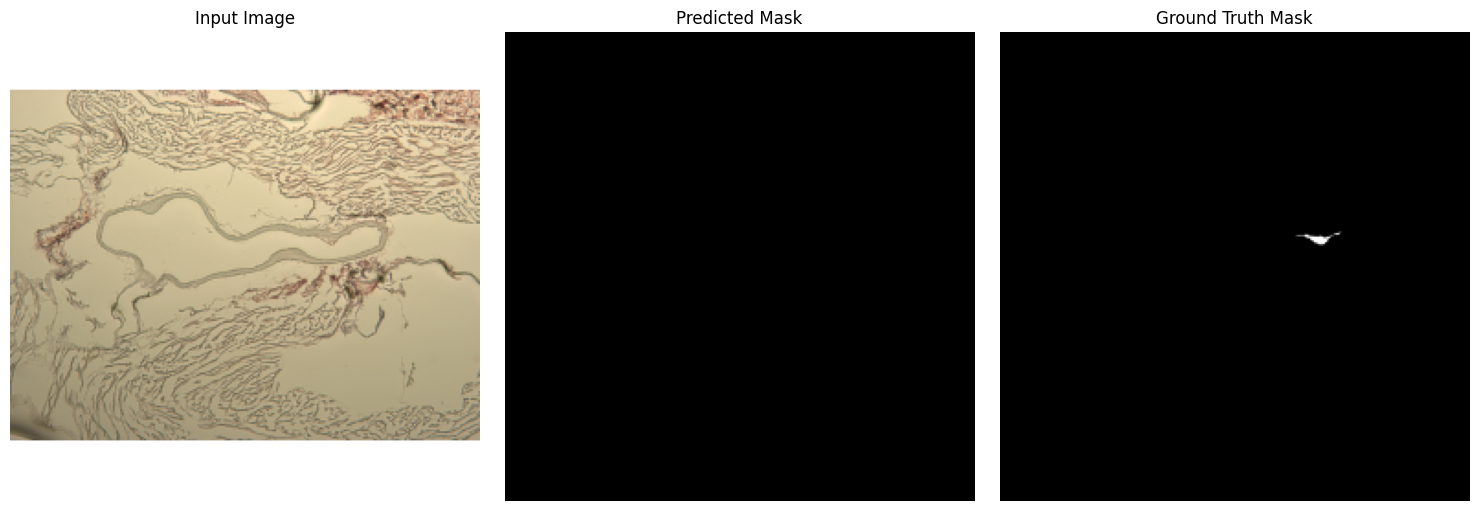

In [97]:
#Worst Prediction
idx = np.argmin(dice_scores)
x = X_test[idx]

sample_batch = np.expand_dims(x, axis=0)

output = unet.predict(sample_batch)

output = np.squeeze(output, axis=0)     # (height, width, 1)
output = np.squeeze(output, axis=-1)    # (height, width)

y_pred = (output >= 0.5).astype(np.int32)  # (height, width)

y_true = y_test[idx]
y_true = np.squeeze(y_true, axis=-1)

plt.figure(figsize=(15, 5))  # Wider figure for three images

plt.subplot(1, 3, 1)
plt.imshow(x)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_true, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()



# Lesion Size Quantification

### UNET

In [ ]:
#Compute median scaling factor
scaling_factors = []

for _, mask, true_area in zip(X, y, y_measurements):

    pixel_count = np.sum(mask)

    if pixel_count == 0:
        continue

    scale = true_area / pixel_count
    scaling_factors.append(scale)

avg_scaling_factor = np.median(scaling_factors)
print(f'Median scaling factor: {avg_scaling_factor}')

sorted(scaling_factors)

In [100]:
from tqdm import tqdm

preds = []

over_count = 0
for x, mask, true_measurement in tqdm(zip(X_test, y_test, y_measurements_test)):
    sample_batch = np.expand_dims(x, axis=0)

    output = unet.predict(sample_batch)

    output = np.squeeze(output, axis=0)
    output = np.squeeze(output, axis=-1)

    y_pred = (output >= 0.5).astype(np.uint8)

    pred_measurement = np.sum(y_pred) * avg_scaling_factor

    preds.append(pred_measurement)

    if pred_measurement > true_measurement:
        over_count += 1


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2it [00:00, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


4it [00:00, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


6it [00:00, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


8it [00:00, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


10it [00:00, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


12it [00:01, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


14it [00:01, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


16it [00:01, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


18it [00:01, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


20it [00:01, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


22it [00:01, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


24it [00:02, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


26it [00:02, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


28it [00:02, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


30it [00:02, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


32it [00:02, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


34it [00:02, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


36it [00:02, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


38it [00:03, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


40it [00:03, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


42it [00:03, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


44it [00:03, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


46it [00:03, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


48it [00:03, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


50it [00:04, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


52it [00:04, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


54it [00:04, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


56it [00:04, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


58it [00:04, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


60it [00:04, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


62it [00:05, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


64it [00:05, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


66it [00:05, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


68it [00:05, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


70it [00:05, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


72it [00:05, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


74it [00:06, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


76it [00:06, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


78it [00:06, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


80it [00:06, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


82it [00:06, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


84it [00:06, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


86it [00:07, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


88it [00:07, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


90it [00:07, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


92it [00:07, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


94it [00:07, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


96it [00:07, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


98it [00:08, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100it [00:08, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


102it [00:08, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


104it [00:08, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


106it [00:08, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


108it [00:08, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


110it [00:09, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


112it [00:09, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


114it [00:09, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


116it [00:09, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


118it [00:09, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


120it [00:09, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


122it [00:10, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


124it [00:10, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


126it [00:10, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


128it [00:10, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


130it [00:10, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


132it [00:10, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


134it [00:10, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


136it [00:11, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


138it [00:11, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


140it [00:11, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


142it [00:11, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


144it [00:11, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


146it [00:11, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


148it [00:12, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


150it [00:12, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


152it [00:12, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


154it [00:12, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


156it [00:12, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


158it [00:12, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


160it [00:13, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


162it [00:13, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


164it [00:13, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


166it [00:13, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


168it [00:13, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


170it [00:13, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


172it [00:14, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


174it [00:14, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


176it [00:14, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


178it [00:14, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


180it [00:14, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


182it [00:14, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


184it [00:15, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


186it [00:15, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


188it [00:15, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


190it [00:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


192it [00:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


194it [00:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


196it [00:16, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


198it [00:16, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


200it [00:16, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


202it [00:16, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


204it [00:16, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


206it [00:16, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


208it [00:17, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


210it [00:17, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


212it [00:17, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


214it [00:17, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


216it [00:17, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


218it [00:17, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


220it [00:17, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


222it [00:18, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


224it [00:18, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


226it [00:18, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


228it [00:18, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


230it [00:18, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


232it [00:19, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


234it [00:19, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


236it [00:19, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


238it [00:19, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


240it [00:19, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


242it [00:19, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


244it [00:20, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


246it [00:20, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


248it [00:20, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


250it [00:20, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


252it [00:20, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


254it [00:20, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


256it [00:21, 12.17it/s]


In [102]:
print(over_count)
print(len(preds))

115
256


In [45]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_areas = np.array(preds)
true_areas = np.array(y_measurements_test)

errors = np.abs(predicted_areas - true_areas)

Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (errors >= lower_bound) & (errors <= upper_bound)
filtered_predicted = predicted_areas[mask]
filtered_true = true_areas[mask]

mae = mean_absolute_error(filtered_true, filtered_predicted)
mse = mean_squared_error(filtered_true, filtered_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(filtered_true, filtered_predicted)

print(f"(MAE): {mae:.4f} μm²")
print(f"(MSE): {mse:.4f} μm²")
print(f"(RMSE): {rmse:.4f} μm²")
print(f"Filtered R² Score: {r2:.4f}")

print(f"Original: {len(predicted_areas)}")
print(f"Filtered: {len(filtered_predicted)}")


(MAE): 7805.0508 μm²
(MSE): 104038413.6162 μm²
(RMSE): 10199.9222 μm²
Filtered R² Score: 0.9889
Original: 256
Filtered: 239


In [175]:
np.mean(true_areas)


np.float64(182974.66148828124)

### UNET + Transformer

In [98]:
from tqdm import tqdm

preds = []

over_count = 0

for x, mask, true_measurement in tqdm(zip(X_test, y_test, y_measurements_test)):
    sample_batch = np.expand_dims(x, axis=0)

    output = unet_transformer.predict(sample_batch)

    output = np.squeeze(output, axis=0)
    output = np.squeeze(output, axis=-1)

    y_pred = (output >= 0.5).astype(np.uint8)

    pred_measurement = np.sum(y_pred) * avg_scaling_factor

    preds.append(pred_measurement)

    if pred_measurement > true_measurement:
        over_count += 1



0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2it [00:00, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


4it [00:00, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


6it [00:00, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


8it [00:00, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


10it [00:00, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


12it [00:01, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


14it [00:01, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


16it [00:01, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


18it [00:01, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


20it [00:01, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


22it [00:01, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


24it [00:01, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


26it [00:02, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


28it [00:02, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


30it [00:02, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


32it [00:02, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


34it [00:02, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


36it [00:03, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


38it [00:03, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


40it [00:03, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


42it [00:03, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


44it [00:03, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


46it [00:03, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


48it [00:03, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


50it [00:04, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


52it [00:04, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


54it [00:04, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


56it [00:04, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


58it [00:04, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


60it [00:04, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


62it [00:05, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


64it [00:05, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


66it [00:05, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


68it [00:05, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


70it [00:05, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


72it [00:05, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


74it [00:06, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


76it [00:06, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


78it [00:06, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


80it [00:06, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


82it [00:06, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


84it [00:06, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


86it [00:07, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


88it [00:07, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


90it [00:07, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


92it [00:07, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


94it [00:07, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


96it [00:07, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


98it [00:08, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100it [00:08, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


102it [00:08, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


104it [00:08, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


106it [00:08, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


108it [00:08, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


110it [00:09, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


112it [00:09, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


114it [00:09, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


116it [00:09, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


118it [00:09, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


120it [00:09, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


122it [00:09, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


124it [00:10, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


126it [00:10, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


128it [00:10, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


130it [00:10, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


132it [00:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


134it [00:11, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


136it [00:11, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


138it [00:11, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


140it [00:11, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


142it [00:11, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


144it [00:11, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


146it [00:12, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


148it [00:12, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


150it [00:12, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


152it [00:12, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


154it [00:12, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


156it [00:12, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


158it [00:13, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


160it [00:13, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


162it [00:13, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


164it [00:13, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


166it [00:13, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


168it [00:13, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


170it [00:14, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


172it [00:14, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


174it [00:14, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


176it [00:14, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


178it [00:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


180it [00:14, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


182it [00:15, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


184it [00:15, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


186it [00:15, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


188it [00:15, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


190it [00:15, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


192it [00:15, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


194it [00:16, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


196it [00:16, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


198it [00:16, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


200it [00:16, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


202it [00:16, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


204it [00:16, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


206it [00:17, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


208it [00:17, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


210it [00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


212it [00:17, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


214it [00:17, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


216it [00:17, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


218it [00:18, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


220it [00:18, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


222it [00:18, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


224it [00:18, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


226it [00:18, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


228it [00:18, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


230it [00:19, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


232it [00:19, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


234it [00:19, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


236it [00:19, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


238it [00:19, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


240it [00:19, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


242it [00:20, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


244it [00:20, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


246it [00:20, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


248it [00:20, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


250it [00:20, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


252it [00:21, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


254it [00:21, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


256it [00:21, 11.99it/s]


In [99]:
print(over_count)
print(len(preds))

113
256


In [47]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_areas = np.array(preds)
true_areas = np.array(y_measurements_test)

errors = np.abs(predicted_areas - true_areas)

Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (errors >= lower_bound) & (errors <= upper_bound)
filtered_predicted = predicted_areas[mask]
filtered_true = true_areas[mask]

mae = mean_absolute_error(filtered_true, filtered_predicted)
mse = mean_squared_error(filtered_true, filtered_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(filtered_true, filtered_predicted)

print(f"(MAE): {mae:.4f} μm²")
print(f"(MSE): {mse:.4f} μm²")
print(f"(RMSE): {rmse:.4f} μm²")
print(f"Filtered R² Score: {r2:.4f}")

print(f"Original: {len(predicted_areas)}")
print(f"Filtered: {len(filtered_predicted)}")

(MAE): 11798.2007 μm²
(MSE): 251006654.7164 μm²
(RMSE): 15843.1895 μm²
Filtered R² Score: 0.9725
Original: 256
Filtered: 245


In [88]:
from skimage import measure, color
from scipy import ndimage
import numpy as np
import pandas as pd
import cv2

def measure_rois(mask):


    mask_filled = ndimage.binary_fill_holes(mask).astype(np.uint8)

    labels = measure.label(mask_filled, connectivity=1)

    # Filter small regions
    min_region_area = 5
    labels_filtered = np.copy(labels)
    properties = measure.regionprops(labels)
    for region in properties:
        if region.area < min_region_area:
            labels_filtered[labels == region.label] = 0

    properties_filtered = measure.regionprops(labels_filtered)

    overlay_img = color.label2rgb(labels_filtered, image=mask, bg_label=0)
    overlay_img = (overlay_img * 255).astype(np.uint8)  # (H, W, 3)

    measurements = []

    for idx, region in enumerate(properties_filtered):
        minr, minc, maxr, maxc = region.bbox

        cv2.rectangle(overlay_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)

        region_label = f'{round(region.area * 90.81, 1)}'
        cv2.putText(overlay_img, region_label, (minc, minr - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

        measurements.append({"Region": idx, "Area": region.area * 90.81})

    measurements_df = pd.DataFrame(measurements)

    return measurements_df, overlay_img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


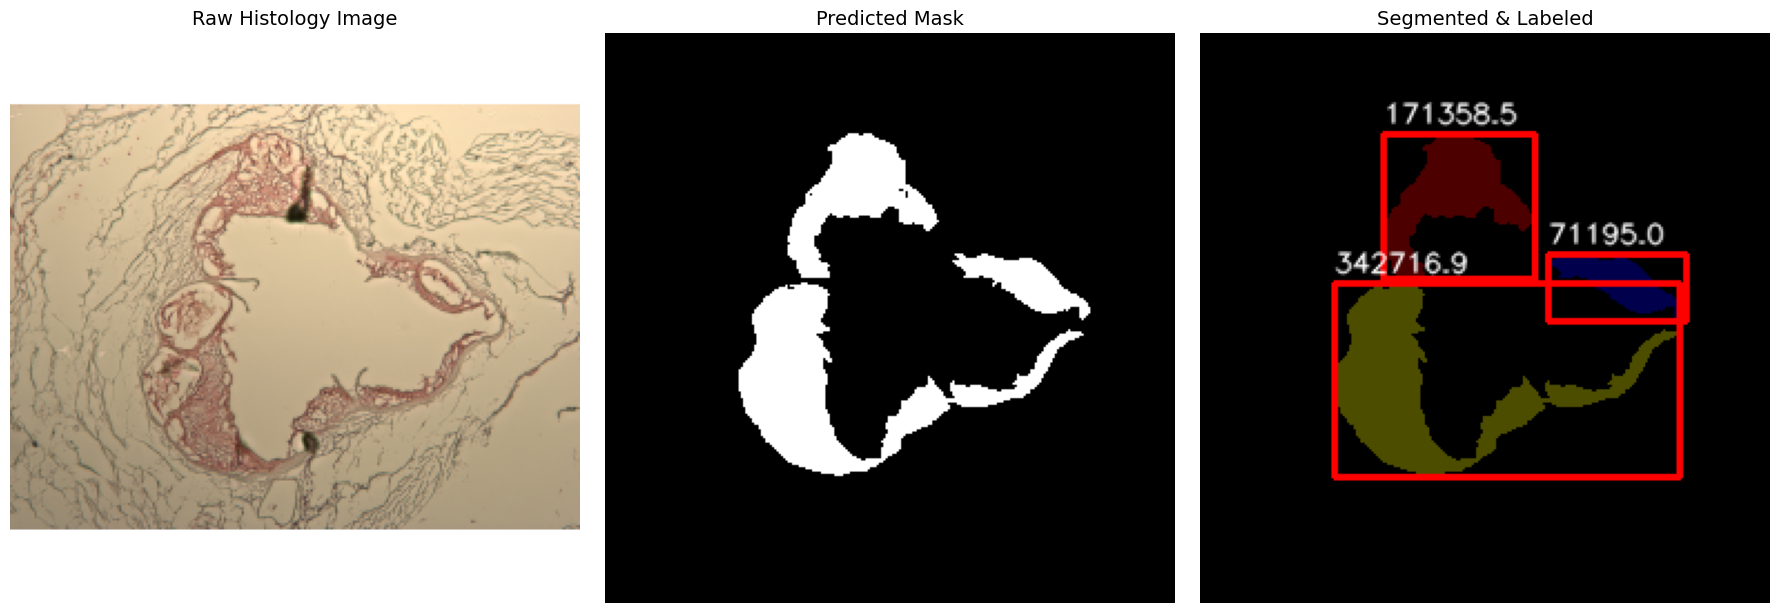

In [101]:
x = X_train[100]
sample_batch = np.expand_dims(x, axis=0)
output = unet_transformer.predict(sample_batch)
output = np.squeeze(output, axis=0)
output = np.squeeze(output, axis=-1)
y_pred = (output >= 0.5).astype(np.uint8)

measurements_df, labeled_overlay = measure_rois(y_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(x)
axes[0].set_title('Raw Histology Image', fontsize=14)
axes[0].axis('off')

axes[1].imshow(y_pred, cmap='gray')
axes[1].set_title('Predicted Mask', fontsize=14)
axes[1].axis('off')

axes[2].imshow(labeled_overlay)
axes[2].set_title('Segmented & Labeled', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()
